In [1]:
!nvidia-smi

Tue May  2 07:29:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    22W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt  # plot
import random
import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
import cv2
import pandas as pd
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import f1_score, accuracy_score



In [5]:
NUM_CLASS = 2
SEED=11
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256

# Utils

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
!mkdir data
!unzip "/content/drive/MyDrive/project2VDT/sourceCode/data.zip" -d "/"

mkdir: cannot create directory ‘data’: File exists
Archive:  /content/drive/MyDrive/project2VDT/sourceCode/data.zip
replace /content/data/happy/10_ffhq_2583.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# Used to Train on Kaggle

# !pip install gdown

# # Get Data From Drive
# !gdown 1TBiFG1AjSBpRKoVovV5zUHbWI4ro14cx

# !unzip /kaggle/working/data.zip -d /kaggle/working/data


# Data

In [15]:
import os
def countFile(link):
    path = link
    num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])

    print("Number of files in directory: ", num_files)

In [16]:
countFile("data/happy")
countFile("data/sad")

Number of files in directory:  6906
Number of files in directory:  4912


In [17]:
# # Still countFile but Kaggle
# countFile("/kaggle/working/data/content/data/happy")
# countFile("/kaggle/working/data/content/data/sad")

In [18]:
np.random.seed(11)

In [41]:
INPUT_PATH = '/content/data/'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            print(img.shape)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [20]:
X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

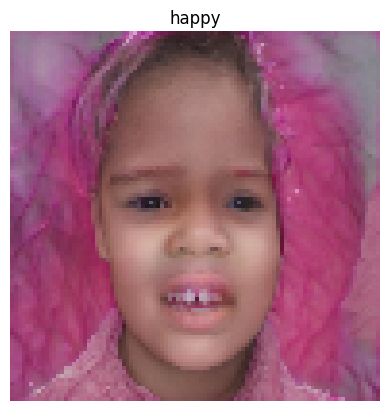

In [21]:
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()

In [22]:
augmentation_layer = Sequential([
    layers.RandomCrop(92, 92, seed=SEED, input_shape=input_shape),
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
], name="data_augmentation_layer")

## Train, Val, Test Split

In [23]:
id_pos = np.where(y == 1)[0]
id_neg = np.where(y == 0)[0]

np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

id_train_neg = id_neg[:int(len(id_neg) * 0.7)]
id_train_pos = id_pos[:int(len(id_pos) * 0.7)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

id_val_neg = id_neg[int(len(id_neg) * 0.7):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.7):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [24]:

#train
x_train = X[id_train]
y_train = y[id_train]
#val
x_val = X[id_val]
y_val = y[id_val]
#test
x_test = X[id_test]
y_test = y[id_test]

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_train = to_categorical(y_train,dtype = 'int32')
y_val = to_categorical(y_val,dtype = 'int32')
y_test = to_categorical(y_test,dtype = 'int32')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8272, 96, 96, 3) - y_train shape: (8272, 2)
x_val shape: (2363, 96, 96, 3) - y_val shape: (2363, 2)
x_test shape: (1183, 96, 96, 3) - y_test shape: (1183, 2)


###Data augmentation

In [25]:
# Tạo một ImageDataGenerator object và cấu hình các phép biến đổi
datagen = ImageDataGenerator(
    rotation_range=20,  # xoay ảnh từ -20 đến +20 độ
    width_shift_range=0.2,  # dịch chuyển theo chiều ngang từ -20% đến +20% của kích thước ảnh
    height_shift_range=0.2,  # dịch chuyển theo chiều dọc từ -20% đến +20% của kích thước ảnh
    horizontal_flip=True  # lật ảnh theo chiều ngang
)

# Fit data generator cho dữ liệu huấn luyện
datagen.fit(x_train)

# Define model

In [26]:
def resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    
    # output has shape of (None, 2)
    output = layers.Dense(NUM_CLASS, activation="softmax")(x)
    model = keras.Model(inputs=base_model.input, outputs=output)
    return model

In [27]:
def resnet_model_with_augment():

    inputs = layers.Input(input_shape)
    x = augmentation_layer(inputs)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASS, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

In [28]:
augmentation_layer = Sequential([
    layers.RandomCrop(92, 92, seed=SEED, input_shape=input_shape),
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
], name="data_augmentation_layer")

In [29]:
def run_experiment(model,name, datagen):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            tfa.metrics.F1Score(num_classes=2)
        ],
    )

    checkpoint_filepath = f"/content/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    if datagen:
        history = model.fit(
            datagen.flow(x_train,
            y_train, batch_size=32), 
            epochs=15, validation_data=(x_val, y_val), 
            callbacks=[checkpoint_callback])
    else: 
        history = model.fit(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=15,
            validation_data = (x_val,y_val),
            callbacks=[checkpoint_callback],
        )

    model.load_weights(checkpoint_filepath)
    _, accuracy, f1_score_res = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print("f1_score: ", f1_score_res)

    return history

In [30]:
resnet_classifier = resnet_model_with_augment()
# resnet_classifier.summary()
resnet_history = run_experiment(resnet_classifier, "RESNET", datagen=None)

Epoch 1/15
33/33 [==============================] - 44s 761ms/step - loss: 0.2944 - accuracy: 0.9004 - f1_score: 0.8977 - val_loss: 59.1045 - val_accuracy: 0.4642 - val_f1_score: 0.3813
Epoch 2/15
33/33 [==============================] - 20s 609ms/step - loss: 0.0974 - accuracy: 0.9657 - f1_score: 0.9647 - val_loss: 5.2819 - val_accuracy: 0.5954 - val_f1_score: 0.5716
Epoch 3/15
33/33 [==============================] - 20s 617ms/step - loss: 0.0644 - accuracy: 0.9770 - f1_score: 0.9764 - val_loss: 0.8885 - val_accuracy: 0.8337 - val_f1_score: 0.8336
Epoch 4/15
33/33 [==============================] - 21s 628ms/step - loss: 0.0587 - accuracy: 0.9798 - f1_score: 0.9792 - val_loss: 0.2512 - val_accuracy: 0.8713 - val_f1_score: 0.8602
Epoch 5/15
33/33 [==============================] - 22s 684ms/step - loss: 0.0596 - accuracy: 0.9784 - f1_score: 0.9778 - val_loss: 0.1755 - val_accuracy: 0.9513 - val_f1_score: 0.9491
Epoch 6/15
33/33 [==============================] - 23s 691ms/step - loss:

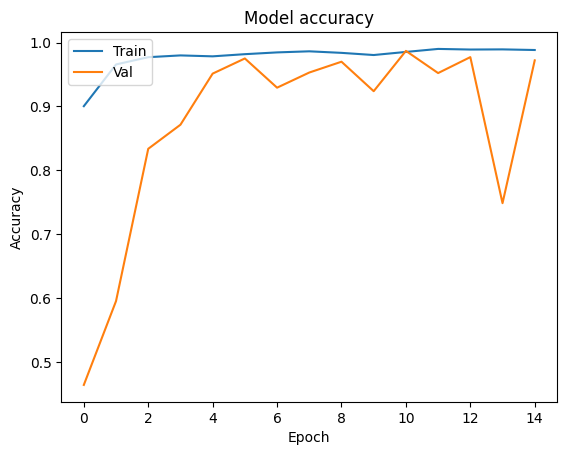

In [31]:
# Plot training & validation accuracy values
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


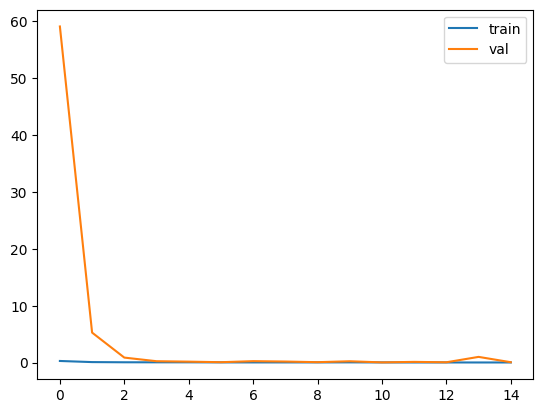

In [58]:
plt.plot(resnet_history.history['loss'], label='train')
plt.plot(resnet_history.history['val_loss'], label='val')
plt.legend()

# PLOT Prediction on Test Set

37/37 [==============================] - 1s 26ms/step
GROUND TRUTH: 
Label 1:  492
Label 0:  691
PREDICTION: 
Label 1:  505
Label 0:  678
f1_score:  0.9809428284854563
accuracy:  0.9839391377852916


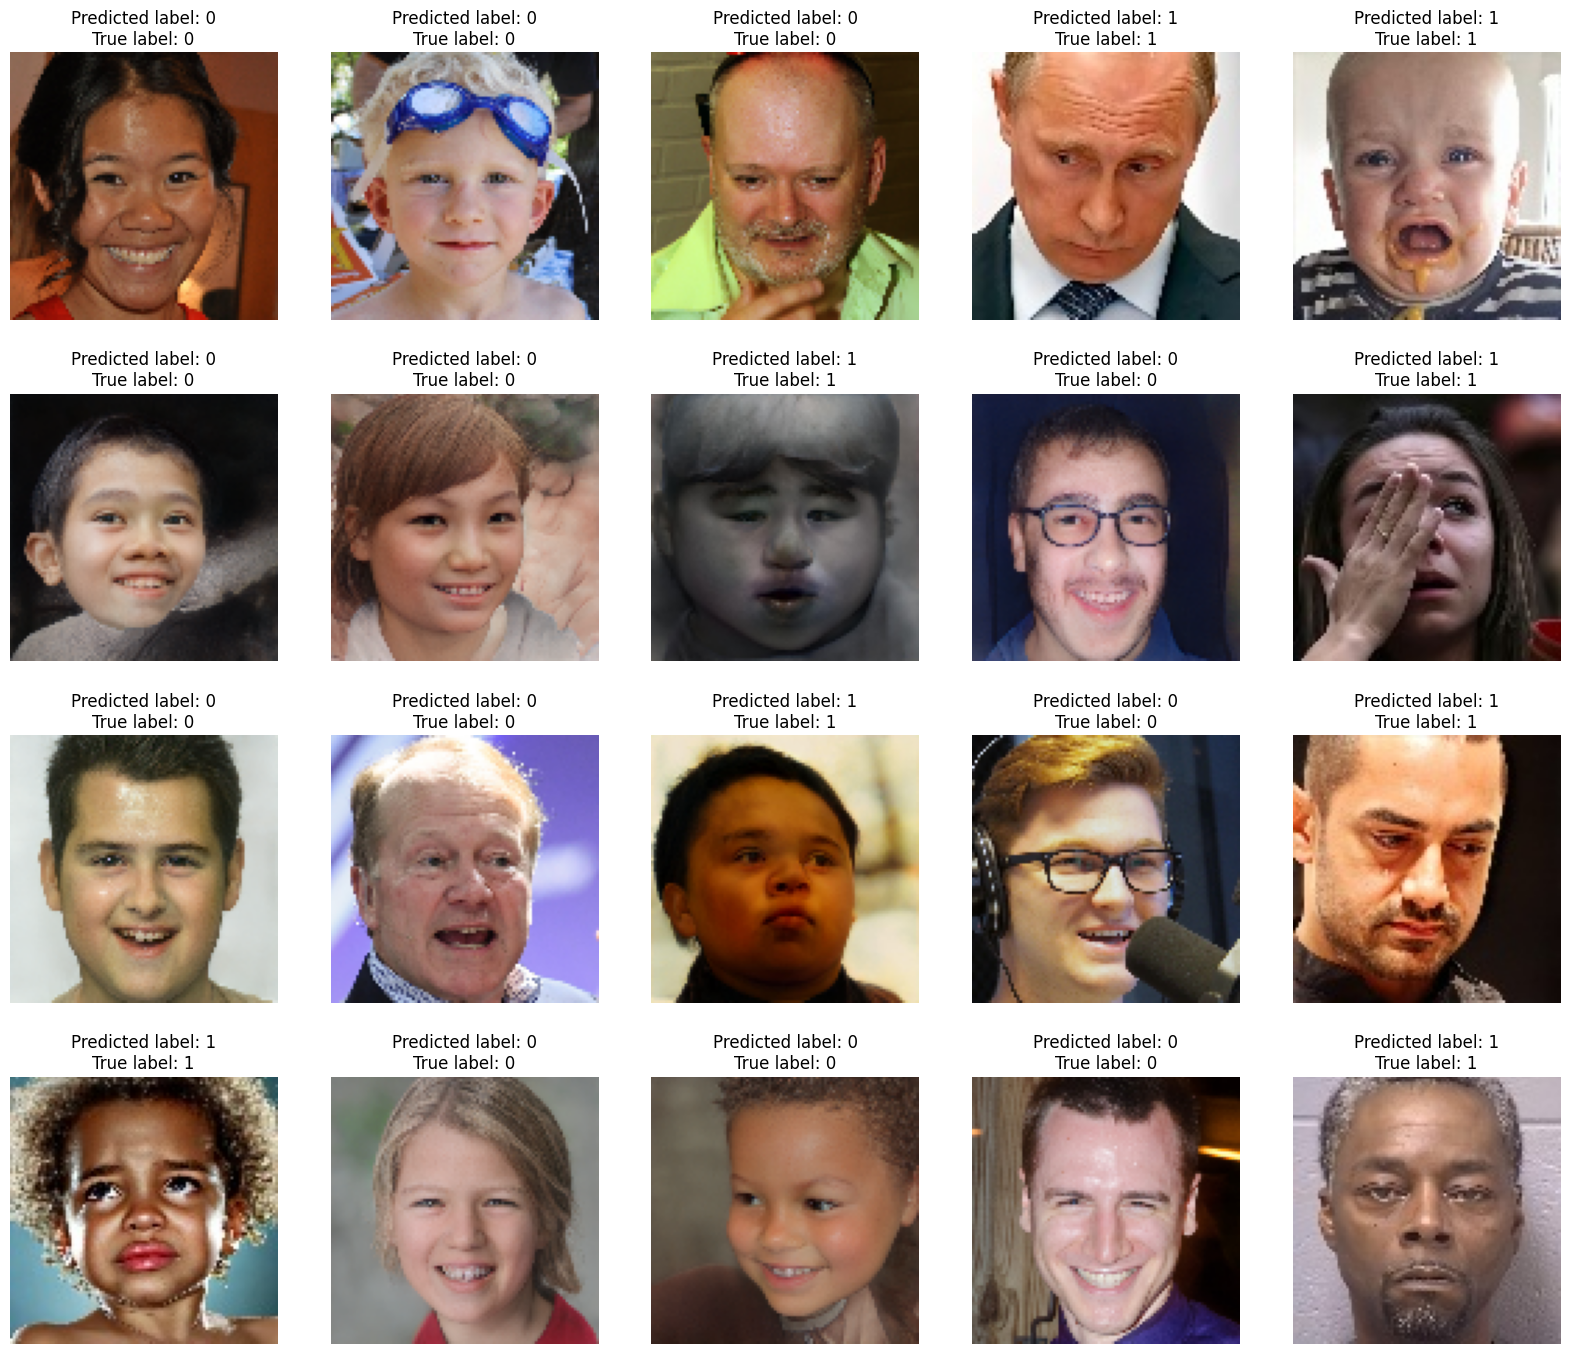

In [56]:
# use model to predict and plot the result
y_pred = resnet_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y_true == 1))
print(f"Label 0: ", np.count_nonzero(y_true == 0))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_pred == 1))
print(f"Label 0: ", np.count_nonzero(y_pred == 0))

print("f1_score: ", f1_score(y_true, y_pred))
print("accuracy: ", accuracy_score(y_true, y_pred))

# plot random 20 x_test and their predicted labels and ground truth labels
fig, axs = plt.subplots(4, 5, figsize=(20, 17))
for i in range(20):
    ax = axs[i//5, i%5]
    index = random.randint(0, len(x_test))
    ax.imshow(x_test[index])
    ax.set_title(f"Predicted label: {y_pred[index]}\nTrue label: {y_true[index]}")
    ax.axis('off')

# PLOT PREDICTION ON INFER SET

In [38]:
INFER_PATH = '/content/drive/MyDrive/project2VDT/sourceCode/InferenceData/'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

In [53]:
X_infer, y_infer = load_images(INFER_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X_infer[0].shape

(567, 567, 3)
(263, 263, 3)
(337, 337, 3)
(302, 302, 3)
(103, 103, 3)
(126, 126, 3)
(628, 634, 3)
(319, 319, 3)
(544, 544, 3)
(559, 559, 3)
(126, 126, 3)
(202, 202, 3)


In [54]:
print(X_infer.shape)

(12, 96, 96, 3)


1/1 [==============================] - 1s 615ms/step
GROUND TRUTH: 
Label 1:  6
Label 0:  6
PREDICTION: 
Label 1:  5
Label 0:  7
f1_score:  0.7272727272727272
accuracy:  0.75


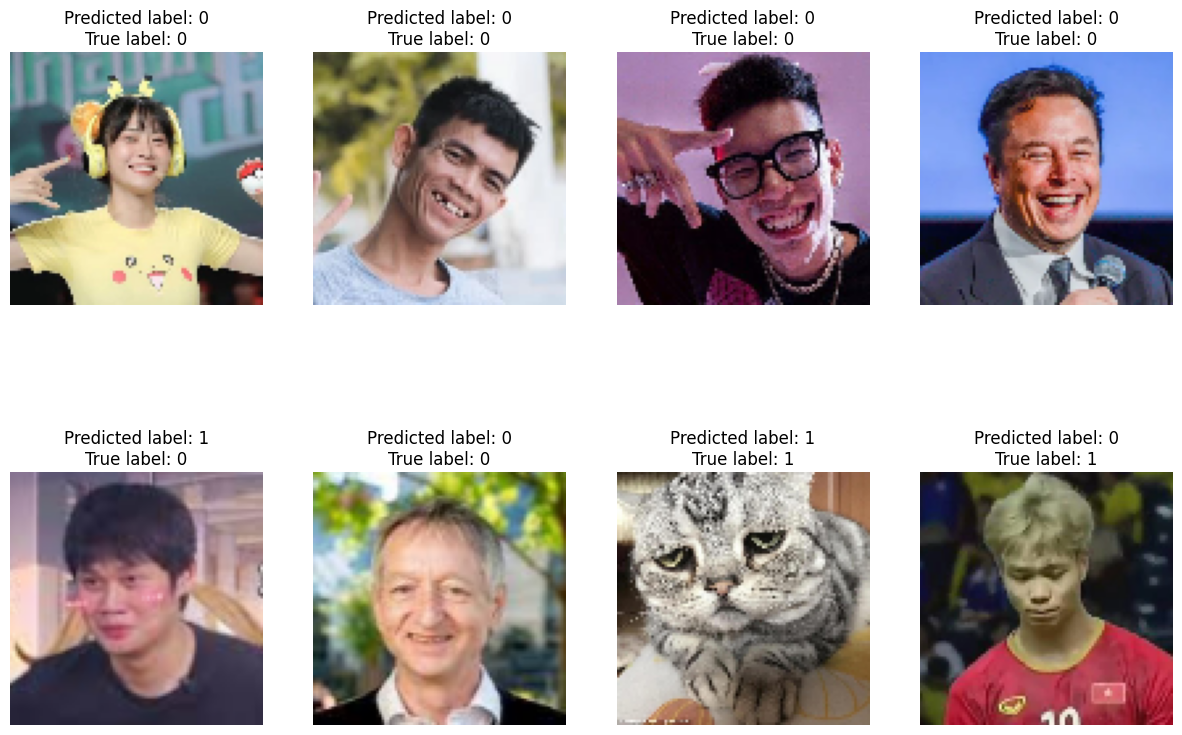

In [55]:
y_infer_pred = resnet_classifier.predict(X_infer)
y_infer_pred = np.argmax(y_infer_pred, axis=1)
y_infer_true = y_infer # y_infer is already in type of [0, 1, 1, 0]

print("GROUND TRUTH: ")
print(f"Label 1: ", np.count_nonzero(y_infer_true == 1))
print(f"Label 0: ", np.count_nonzero(y_infer_true == 0))


print("PREDICTION: ")
print(f"Label 1: ", np.count_nonzero(y_infer_pred == 1))
print(f"Label 0: ", np.count_nonzero(y_infer_pred == 0))

# print f1_score & accuracy
print("f1_score: ", f1_score(y_infer_true, y_infer_pred))
print("accuracy: ", accuracy_score(y_infer_true, y_infer_pred))

# Plot random 8 images in inference data and their predicted labels and ground truth labels
fig, axs = plt.subplots(2, 4, figsize=(15, 10))
for i in range(8):
    ax = axs[i//4, i%4]
    # index = random.randint(0, len(X_infer-1))
    ax.imshow(X_infer[i])
    ax.set_title(f"Predicted label: {y_infer_pred[i]}\nTrue label: {y_infer_true[i]}")
    ax.axis('off')